# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.25, 0.25]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$

In [1]:
NAME = "1_2"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

# layers = [3] + [32]*2 + [2] # (x, t) -> (u, v)
layers = [2] + [32]*2 + [2]
c0 = 6.0
# w0 = jnp.array([[1.0, 1.0, 1.0]]).T # (w_x, w_t)
w0 = jnp.array([[30.0, 30.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)
# direct_params = init_tanh_params(subkey, layers)

domain = jnp.array([[-0.25, 0.], [0.25, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

# @jax.jit
# def model(params, xt): # for predictions
# 	# first, normalize to [-1, 1] <- enforce periodic bc
# # 	xt = jnp.sin(2.0*jnp.pi*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - jnp.pi)
# 	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
# 	xt = index_update(xt, index[:,0], jnp.sin(2*jnp.pi*xt[:,0]/spatial_width))
# 	xt = index_update(xt, index[:,1], jnp.cos(2*jnp.pi*xt[:,1]/spatial_width))
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
# 	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
# 	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model(params, xt): # for predictions
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model_(params, xt): # for derivatives
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model_)
hessian = hessian_fn(model_)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	direct_params = params
	
# 	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
# 	# jacobian[i] = [[du/dx, du/dt],
# 	#                [dv/dx, dv/dt]]
# 	# i: the i^th input
# 	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
# 	# hessian[i] = [
#     #				[[du/dxx, du/dxy],
# 	#                [du/dxy, du/dyy]],
# 	#               [[dv/dxx, dv/dxy],
# 	#                [dv/dxy, dv/dyy]]
# 	#              ]
# 	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
# 	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
	duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
	du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
	
	duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
	du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
	
# 	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
# 	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
# 	loss_c = loss_c1 + loss_c2
	loss_c = 0.0
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
	loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
	loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
	loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
	loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
	loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
	loss_nt = loss_n_t1 + loss_n_t2
	loss_nx = loss_n_x1 + loss_n_x2
	loss_nxx = loss_n_xx1 + loss_n_xx2
	
	return loss_c, loss_d, loss_nt, loss_nx, loss_nxx


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx, loss_c, loss_d, loss_nt, loss_nx, loss_nxx, l1, l2

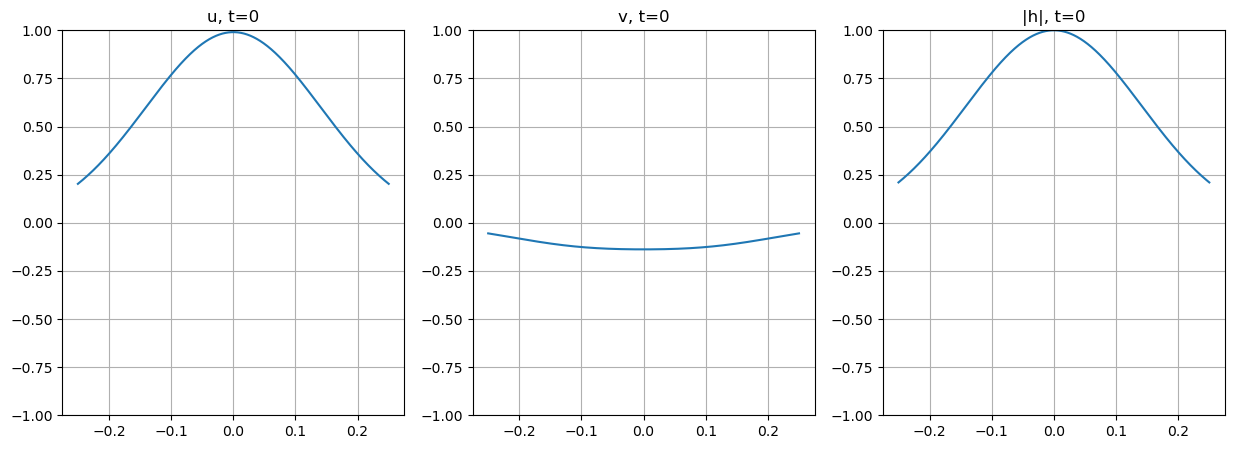

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
# x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
# x_i_l = jnp.linspace(domain[0, 0], domain[0, 0]+0.05, 100).reshape((-1, 1))
# x_i_r = jnp.linspace(domain[1, 0]-0.05, domain[1, 0], 100).reshape((-1, 1))
# x_i = jnp.vstack([x_i, x_i_l, x_i_r])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - 1/2*epsilon**2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(1/2*epsilon**2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = 0
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train

lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
batch_size = {"dirichlet": 100, "collocation": 1, "neumann": 100}
weights = {"c": 0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1e-1, "l1": 0, "l2": 0}

key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
Collocation = Time_Marching_Generator(subkeys[3], x_c, [0.0, 0.0], n_cx, iterations, 1)

params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"collocation": dataset_Collocation(*d[:2]),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/16, 00:46:16, Iteration: 0, Train Loss: 2.6765e+02, c: 0.0000e+00, d: 1.2538e+00, nt: 5.3877e+01, nx: 3.4849e+01, nxx: 1.7767e+03, l1_reg: 2.1055e+03, l2_reg: 6.6343e+04
2020/08/16, 00:46:23, Iteration: 500, Train Loss: 4.1518e+00, c: 0.0000e+00, d: 7.1086e-02, nt: 1.1235e+00, nx: 9.9499e-01, nxx: 1.9622e+01, l1_reg: 2.1006e+03, l2_reg: 6.6226e+04
2020/08/16, 00:46:29, Iteration: 1000, Train Loss: 2.5536e+00, c: 0.0000e+00, d: 8.0287e-03, nt: 6.7286e-01, nx: 2.3606e-01, nxx: 1.6367e+01, l1_reg: 2.0994e+03, l2_reg: 6.6202e+04
2020/08/16, 00:46:35, Iteration: 1500, Train Loss: 1.3932e+00, c: 0.0000e+00, d: 4.2574e-03, nt: 3.5861e-01, nx: 1.3104e-01, nxx: 8.9933e+00, l1_reg: 2.0985e+03, l2_reg: 6.6182e+04
2020/08/16, 00:46:41, Iteration: 2000, Train Loss: 1.4696e+00, c: 0.0000e+00, d: 5.5918e-03, nt: 3.2916e-01, nx: 1.8061e-01, nxx: 9.5423e+00, l1_reg: 2.0977e+03, l2_reg: 6.6166e+04
2020/08/16, 00:46:48, Iteration: 2500, Train Loss: 1.5567e+00, c: 0.0000e+00, d: 3.6746e-03, nt: 3.

2020/08/16, 00:51:25, Iteration: 23000, Train Loss: 5.8290e-01, c: 0.0000e+00, d: 2.5468e-03, nt: 9.3622e-02, nx: 8.7511e-02, nxx: 3.9922e+00, l1_reg: 2.0851e+03, l2_reg: 6.5969e+04
2020/08/16, 00:51:32, Iteration: 23500, Train Loss: 8.2800e-01, c: 0.0000e+00, d: 4.6686e-03, nt: 1.1530e-01, nx: 1.3016e-01, nxx: 5.7787e+00, l1_reg: 2.0849e+03, l2_reg: 6.5965e+04
2020/08/16, 00:51:39, Iteration: 24000, Train Loss: 6.2814e-01, c: 0.0000e+00, d: 2.0008e-03, nt: 1.2571e-01, nx: 7.9777e-02, nxx: 4.2065e+00, l1_reg: 2.0846e+03, l2_reg: 6.5962e+04
2020/08/16, 00:51:46, Iteration: 24500, Train Loss: 8.5587e-01, c: 0.0000e+00, d: 4.1103e-03, nt: 1.3012e-01, nx: 1.2273e-01, nxx: 5.9891e+00, l1_reg: 2.0844e+03, l2_reg: 6.5958e+04
2020/08/16, 00:51:53, Iteration: 25000, Train Loss: 9.1424e-01, c: 0.0000e+00, d: 3.6955e-03, nt: 1.5376e-01, nx: 1.0656e-01, nxx: 6.5023e+00, l1_reg: 2.0842e+03, l2_reg: 6.5955e+04
2020/08/16, 00:52:00, Iteration: 25500, Train Loss: 9.0813e-01, c: 0.0000e+00, d: 4.2974e-

2020/08/16, 00:56:39, Iteration: 46000, Train Loss: 6.9781e-01, c: 0.0000e+00, d: 3.3734e-03, nt: 1.5426e-01, nx: 1.0922e-01, nxx: 4.3096e+00, l1_reg: 2.0739e+03, l2_reg: 6.5809e+04
2020/08/16, 00:56:46, Iteration: 46500, Train Loss: 8.0880e-01, c: 0.0000e+00, d: 4.3636e-03, nt: 9.9113e-02, nx: 1.3990e-01, nxx: 5.6542e+00, l1_reg: 2.0737e+03, l2_reg: 6.5806e+04
2020/08/16, 00:56:53, Iteration: 47000, Train Loss: 4.7058e-01, c: 0.0000e+00, d: 2.8901e-03, nt: 9.5074e-02, nx: 6.4198e-02, nxx: 3.0842e+00, l1_reg: 2.0736e+03, l2_reg: 6.5802e+04
2020/08/16, 00:57:00, Iteration: 47500, Train Loss: 3.7561e-01, c: 0.0000e+00, d: 3.5757e-03, nt: 9.1678e-02, nx: 5.9170e-02, nxx: 2.2118e+00, l1_reg: 2.0734e+03, l2_reg: 6.5799e+04
2020/08/16, 00:57:07, Iteration: 48000, Train Loss: 4.8302e-01, c: 0.0000e+00, d: 2.9568e-03, nt: 7.4518e-02, nx: 6.6099e-02, nxx: 3.3945e+00, l1_reg: 2.0732e+03, l2_reg: 6.5796e+04
2020/08/16, 00:57:14, Iteration: 48500, Train Loss: 4.6911e-01, c: 0.0000e+00, d: 3.0670e-

2020/08/16, 01:01:57, Iteration: 69000, Train Loss: 3.0063e-01, c: 0.0000e+00, d: 1.3647e-03, nt: 7.3764e-02, nx: 4.4358e-02, nxx: 1.8114e+00, l1_reg: 2.0649e+03, l2_reg: 6.5648e+04
2020/08/16, 01:02:04, Iteration: 69500, Train Loss: 2.8966e-01, c: 0.0000e+00, d: 2.3922e-03, nt: 4.7889e-02, nx: 4.6535e-02, nxx: 1.9284e+00, l1_reg: 2.0649e+03, l2_reg: 6.5644e+04
2020/08/16, 01:02:10, Iteration: 70000, Train Loss: 3.1429e-01, c: 0.0000e+00, d: 3.7274e-03, nt: 8.6085e-02, nx: 4.6674e-02, nxx: 1.7780e+00, l1_reg: 2.0647e+03, l2_reg: 6.5641e+04
2020/08/16, 01:02:17, Iteration: 70500, Train Loss: 2.8458e-01, c: 0.0000e+00, d: 2.3841e-03, nt: 4.8429e-02, nx: 5.2967e-02, nxx: 1.8080e+00, l1_reg: 2.0646e+03, l2_reg: 6.5637e+04
2020/08/16, 01:02:24, Iteration: 71000, Train Loss: 2.2292e-01, c: 0.0000e+00, d: 2.2099e-03, nt: 5.9691e-02, nx: 3.3299e-02, nxx: 1.2772e+00, l1_reg: 2.0645e+03, l2_reg: 6.5634e+04
2020/08/16, 01:02:31, Iteration: 71500, Train Loss: 3.5253e-01, c: 0.0000e+00, d: 2.2162e-

2020/08/16, 01:07:12, Iteration: 92000, Train Loss: 2.2722e-01, c: 0.0000e+00, d: 3.0893e-03, nt: 6.5320e-02, nx: 3.4518e-02, nxx: 1.2429e+00, l1_reg: 2.0613e+03, l2_reg: 6.5495e+04
2020/08/16, 01:07:19, Iteration: 92500, Train Loss: 2.4391e-01, c: 0.0000e+00, d: 3.2588e-03, nt: 4.7025e-02, nx: 4.5098e-02, nxx: 1.4853e+00, l1_reg: 2.0612e+03, l2_reg: 6.5491e+04
2020/08/16, 01:07:26, Iteration: 93000, Train Loss: 1.3319e-01, c: 0.0000e+00, d: 1.8969e-03, nt: 2.8333e-02, nx: 2.8353e-02, nxx: 7.4607e-01, l1_reg: 2.0611e+03, l2_reg: 6.5488e+04
2020/08/16, 01:07:33, Iteration: 93500, Train Loss: 2.2870e-01, c: 0.0000e+00, d: 2.3301e-03, nt: 7.6184e-02, nx: 3.0151e-02, nxx: 1.2004e+00, l1_reg: 2.0611e+03, l2_reg: 6.5485e+04
2020/08/16, 01:07:40, Iteration: 94000, Train Loss: 1.5312e-01, c: 0.0000e+00, d: 1.6192e-03, nt: 5.7648e-02, nx: 1.9444e-02, nxx: 7.4406e-01, l1_reg: 2.0609e+03, l2_reg: 6.5482e+04
2020/08/16, 01:07:47, Iteration: 94500, Train Loss: 1.6776e-01, c: 0.0000e+00, d: 3.2185e-

In [ ]:
from scipy.io import loadmat

uv_true = loadmat("ex1_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.25, 0.25])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 51)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

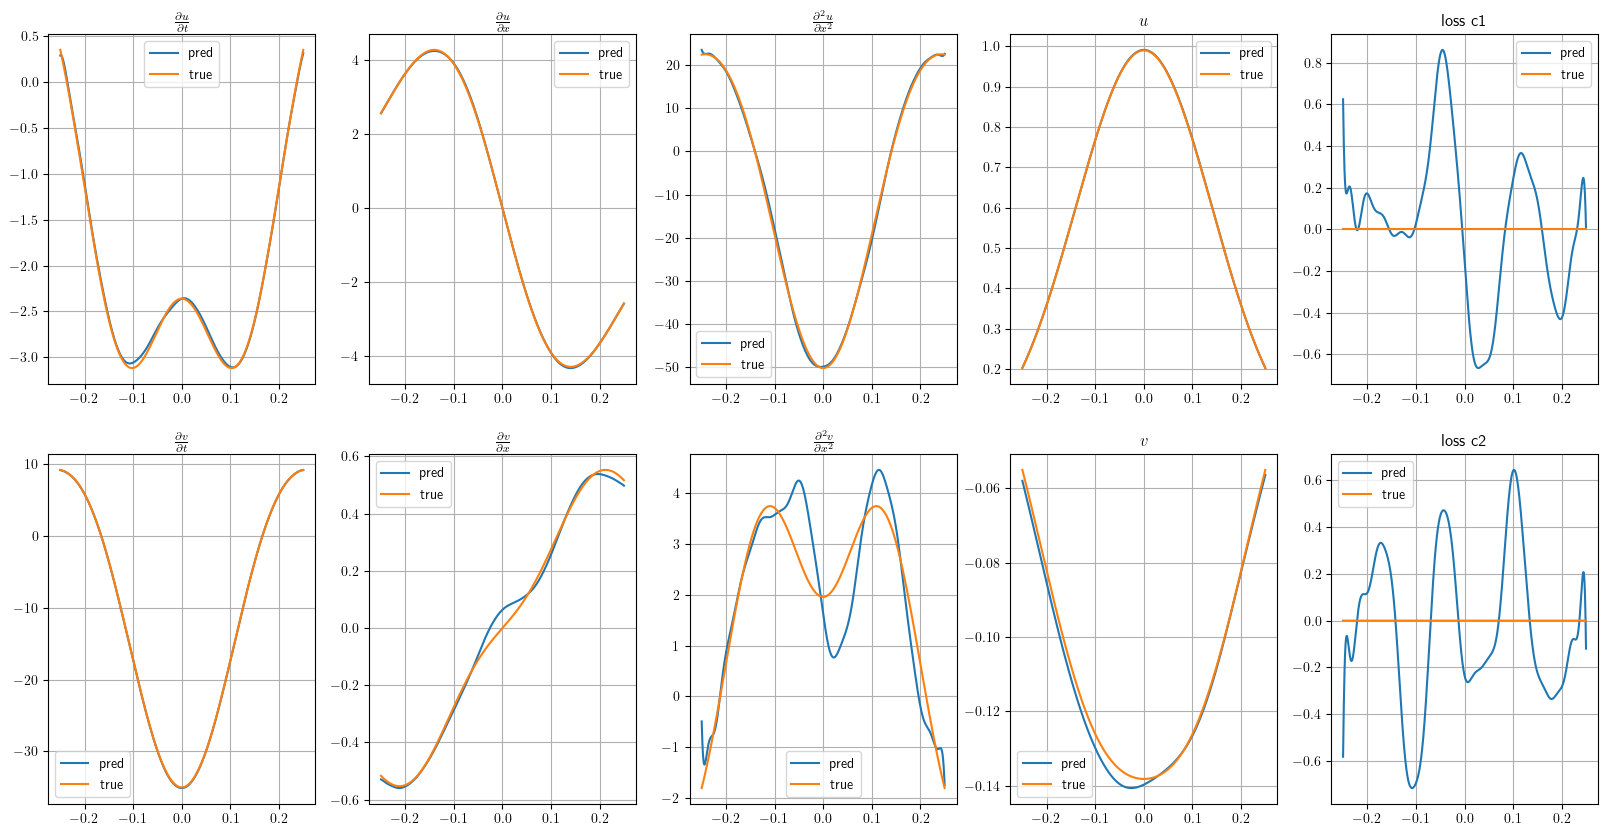

In [7]:
x = jnp.linspace(*domain[:, 0], 1000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
x